#  Instalamos e importamos librerías necesarias

In [1]:
!pip install pydub
!apt-get install ffmpeg -y
!pip install gdown
!pip install tensorflow==2.17.1 tensorflow-io==0.32.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.1
    Uninstalling tensorflow-io-gcs-filesystem-0.37.1:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.1


In [2]:
import os
import pathlib
import librosa


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from IPython import display
import IPython.display as ipd

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from google.colab import drive
from pydub import AudioSegment
from pydub.utils import mediainfo

# Activamos una GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de datasets desde Tensorflow Datasets

Este código es el que utilizamos en un principio para descargar los datasets.
Luego los guardamos en el drive y terminamos utilizando un dataset reducido con solo 800 audios (200 de cada idioma: Español, Inglés, Francés, y Japonés)

In [ ]:
# Cargo los subdatasets
es_dataset, es_info = tfds.load('xtreme_s/fleurs.es_419', split = 'train', with_info=True, as_supervised=True)
en_dataset, en_info = tfds.load('xtreme_s/fleurs.en_us', split = 'train', with_info=True, as_supervised=True)
fr_dataset, fr_info = tfds.load('xtreme_s/fleurs.fr_fr', split = 'train', with_info=True, as_supervised=True)
ja_dataset, ja_info = tfds.load('xtreme_s/fleurs.ja_jp', split = 'train', with_info=True, as_supervised=True)

# De los subdatasets me quedo solo con train ya que tiene muchos ejemplos (es innecesario traer los otros ejemplos tambien) y armo los ejemplos (audio, idioma)
def add_language_label(dataset, label):
    dataset = dataset.map(lambda audio, _: (audio, label))
    return dataset

es_dataset = add_language_label(es_dataset, 0)
en_dataset = add_language_label(en_dataset, 1)
fr_dataset = add_language_label(fr_dataset, 2)
ja_dataset = add_language_label(ja_dataset, 3)

# Ver cual de los subdataset tiene menor data y de cada subdataset tomar esa cantidad de ejemplos (para balancear)
num_audios_es = len(es_dataset)
num_audios_en = len(en_dataset)
num_audios_fr = len(fr_dataset)
num_audios_ja = len(ja_dataset)

print(f"Número de audios en el dataset español: {num_audios_es}")
print(f"Número de audios en el dataset inglés: {num_audios_en}")
print(f"Número de audios en el dataset francés: {num_audios_fr}")
print(f"Número de audios en el dataset japonés: {num_audios_ja}")

# Tomamos la misma cantidad de audios para todos los datasets
cantidad = min(num_audios_es, num_audios_en, num_audios_fr, num_audios_ja)

es_dataset = es_dataset.take(cantidad)
en_dataset = en_dataset.take(cantidad)
fr_dataset = fr_dataset.take(cantidad)
ja_dataset = ja_dataset.take(cantidad)

# Combinamos los subdatasets
combined_dataset = es_dataset.concatenate(en_dataset).concatenate(fr_dataset).concatenate(ja_dataset)

# Hacemos shuffle del combined_dataset
combined_dataset = combined_dataset.shuffle(buffer_size=10000)

# Hacemos split del combined_dataset en train, val
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset = combined_dataset.take(train_size)
val_dataset = combined_dataset.skip(train_size)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: 

# Carga de datset reducido desde Google Drive

Como dijimos anteriormente, vamos a usar un dataset reducido que cargamos desde Google Drive

Montamos el drive y nos descargamos el dataset reducido desde ahí

In [ ]:
drive.mount('/content/drive')

!gdown 'https://drive.google.com/drive/folders/1ngqU3qd6xUWnwvIXNd8PFvSnFjEEX2vL?usp=drive_link'

Mounted at /content/drive
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1ngqU3qd6xUWnwvIXNd8PFvSnFjEEX2vL?usp=drive_link
To: /content/1ngqU3qd6xUWnwvIXNd8PFvSnFjEEX2vL?usp=drive_link
1.19MB [00:00, 12.7MB/s]


Verificamos que la carpeta se haya cargado correctamente y tenga los archivos necesarios (una carpeta por cada idioma)

In [ ]:
!ls /content/drive/My\ Drive/datasets_tensorflow/dataset_reducido


español  frances  ingles  japones


## Dividimos los datos en train y validación

Dividimos los datos en train y val, dejando solo los primeros 10 segundos de cada audio. Los que son más cortos se rellenan con 0 y los que son más largos los corta.

In [ ]:
import tensorflow_io as tfio
import tensorflow as tf

# Ruta principal de los datos
data_dir = "/content/drive/My Drive/datasets_tensorflow/dataset_reducido"

# Divide los datos en entrenamiento y validación usando audio_dataset_from_directory
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2, # 20% para validación
    seed=0,
    shuffle=True,
    subset='both',
    output_sequence_length = 160000
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


## Praparamos los datos

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 160000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

El dataset contiene un solo canal de audio por clip, usamos 'tf.squeeze' para descartar el eje extra.

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 160000)
(64,)


## Ploteamos algunos ejemplos

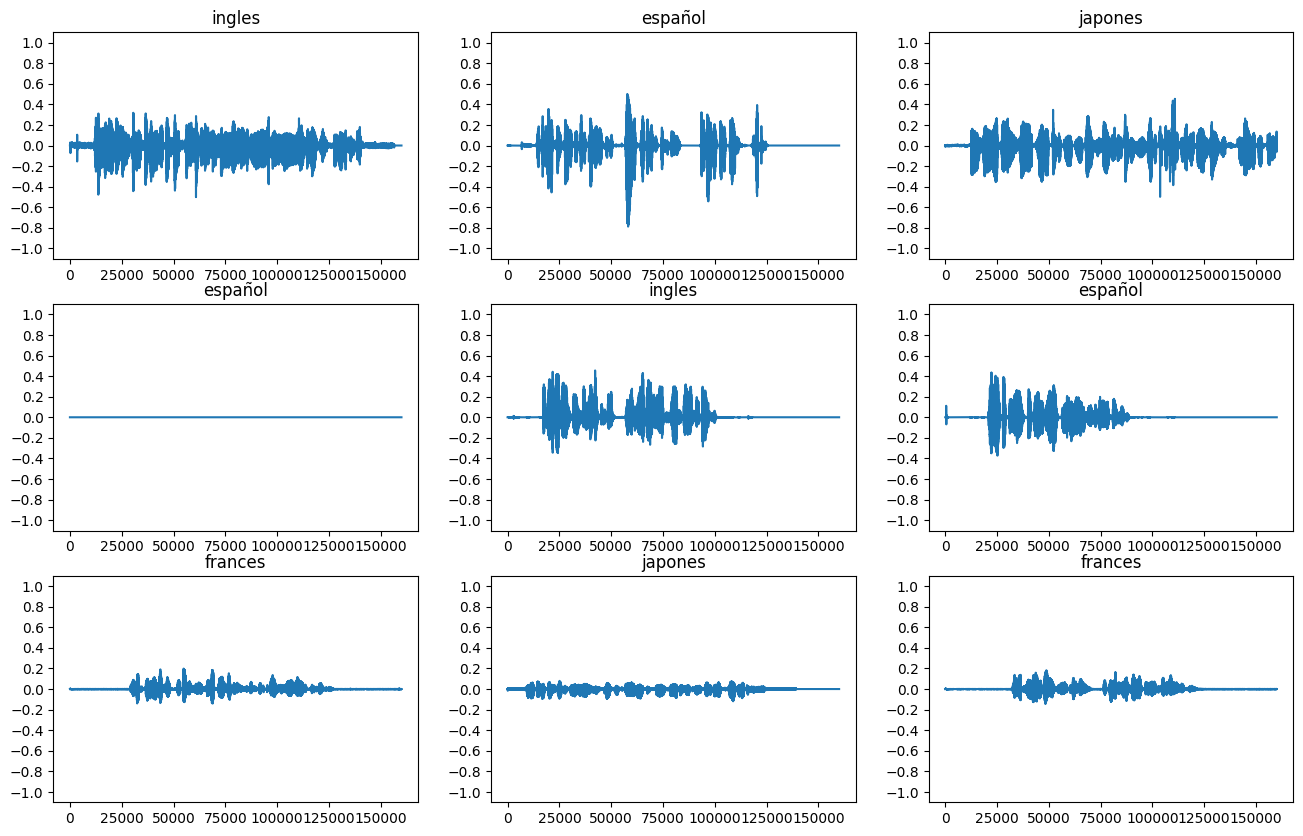

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convertir forma de ondas a espectogramas

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Escuchamos algunos ejemplos con sus respectivas etiquetas

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ingles
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: español
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: japones
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


## Definimos una función para mostrar el espectrograma:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Ploteamos formas de onda y sus respectivos espectrogramas.

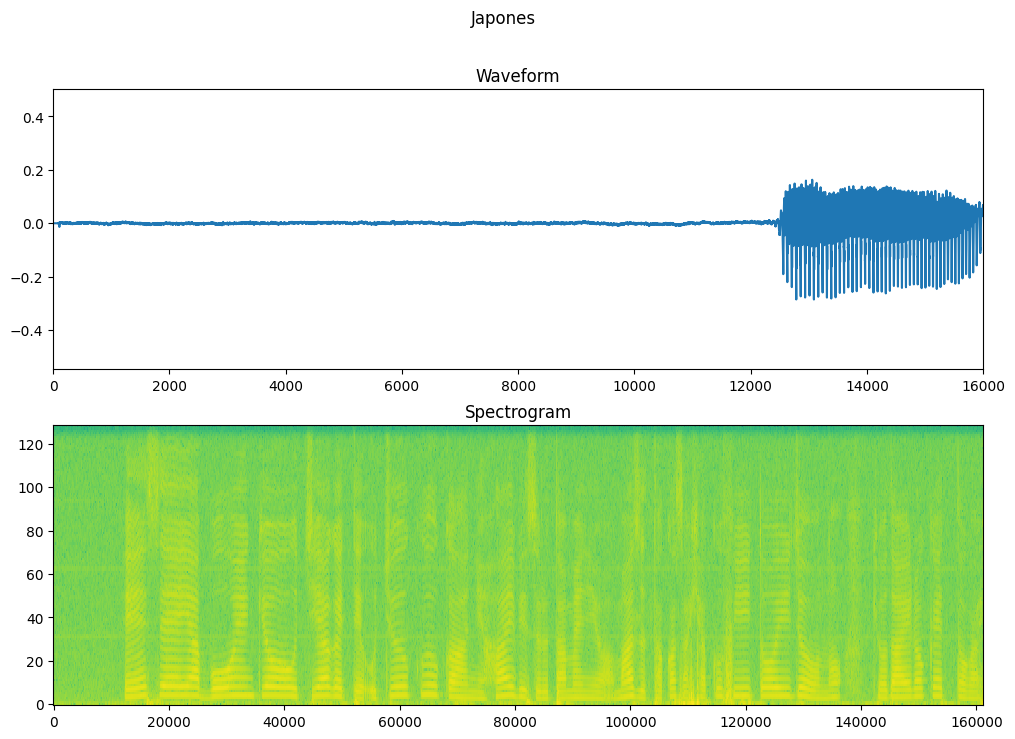

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

### Creamos un dataset de espectrogramas utilizando la función definida.

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

### Examinar el espectrograma para distintos ejemplos del dataset.

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

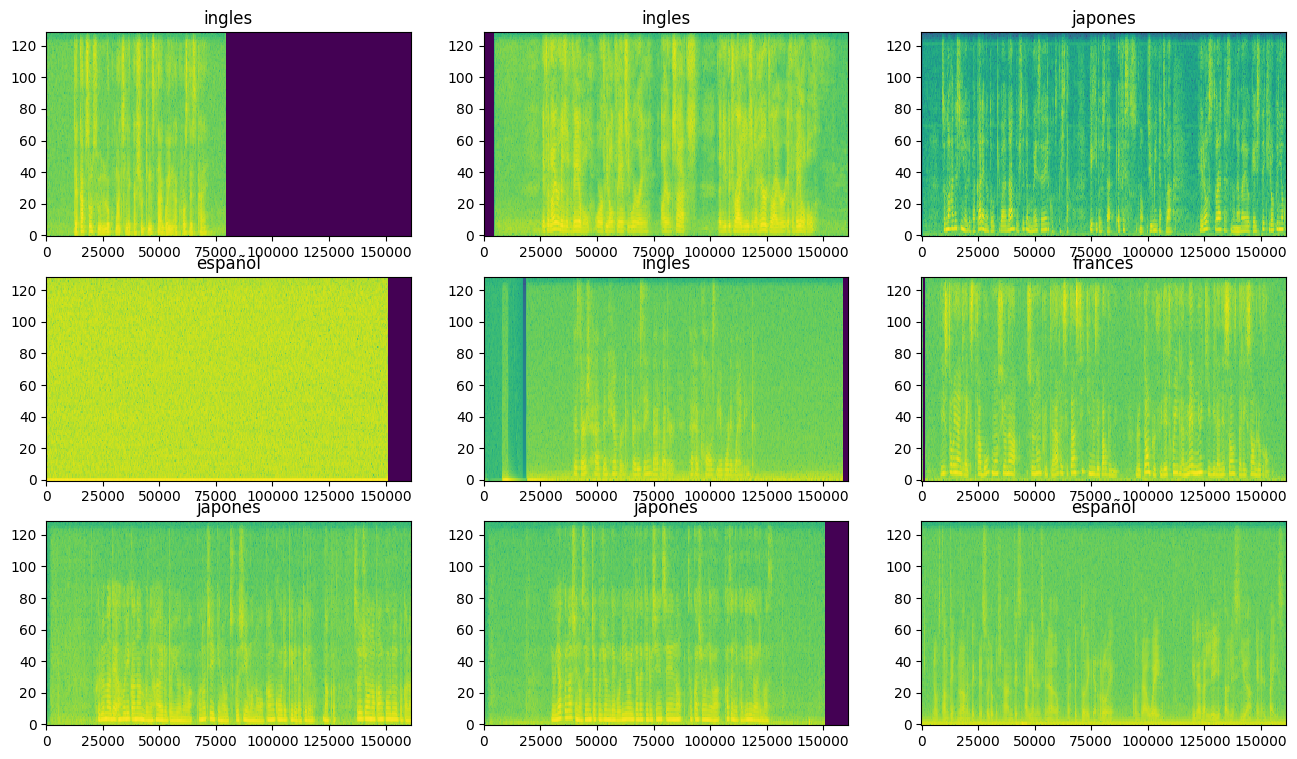

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Carga los datos con un shuffle, para evitar que el modelo aprenda un patrón de los datos

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Vemos las dimensiones del espectograma original para luego hacer un Resizing correcto

In [ ]:
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Ejemplo con un audio del dataset
for audio, _ in train_ds.take(1):
    spectrogram = get_spectrogram(audio)
    print(f"Dimensiones del espectrograma original: {spectrogram.shape}")


Dimensiones del espectrograma original: (64, 1249, 129)


# Modelo con CNNs

## Construir y Entrenar el Modelo

Definimos un modelo de clasificación utilizando una arquitectura basada en Redes Neuronales Convolucionales (CNN) para procesar espectrogramas y predecir la clase correspondiente (idioma del audio).

*Nota:* En este caso, también probamos agregando complejidad, agregando más capas, y agregando más neuronas por capas, pero el modelo empezaba a overfittear, y con un modelo más simple, el accuracy (tanto de train como de val) empezaba a bajar

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(512, 128),
    layers.Conv2D(4, 3, activation='relu'),
    layers.Dropout(0.6),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.8),
    layers.Dense(num_labels, activation='softmax'),
])

model_cnn.summary()

Input shape: (1249, 129, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)                │ (None, 512, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 510, 126, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 510, 126, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 255, 63, 4)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 64260)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64260)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │         257,044 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,084 (1004.23 KB)

 Trainable params: 257,084 (1004.23 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo

In [ ]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos el modelo durante 50 epocas con Early Stopping para frenar el entrenamiento de manera automática si el modelo deja de mejorar, lo que evita el sobreentrenamiento y ahorra tiempo computacional.

In [ ]:
EPOCHS = 50
history_cnn = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, patience=10),
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.3223 - loss: 1.7480 - val_accuracy: 0.5312 - val_loss: 1.0875
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5856 - loss: 1.0052 - val_accuracy: 0.5813 - val_loss: 0.9946
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6493 - loss: 0.8473 - val_accuracy: 0.6438 - val_loss: 0.9482
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6950 - loss: 0.7975 - val_accuracy: 0.6438 - val_loss: 0.9294
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7133 - loss: 0.7400 - val_accuracy: 0.6500 - val_loss: 0.9069
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7714 - loss: 0.6335 - val_accuracy: 0.6500 - val_loss: 0.8831
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8003 - loss: 0.5922 - val_accuracy: 0.7188 - val_loss: 0.8488
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7965 - loss: 0.5506 - val_accuracy: 0.7125 - 

Miramos las dimensiones del espectrograma original (1249, 129), y en base a eso cambiamos el Resizing, hasta quedarnos con (512,129) que nos pareció un valor correcto ara este caso

Además, también fuimos probando con diferentes estructuras de modelo (con más capas, y con más neuronas por capas) pero no llegamos a un valor mejor que 0.7937 de val_accuracy.
Si bien, en el accuracy de train tenemos un 0.9309 y sabemos que está overfitteando, intentamos un montón de maneras de bajarle la complejidad al modelo y sin embargo no cambia demasiado. Así que decidimos quedarnos con estos valores que son los que mejor dan en la métrica de validación.


Ploteamos el accuracy y loss tanto de train como de test para ver como evolucionan

Text(0, 0.5, 'Accuracy [%]')

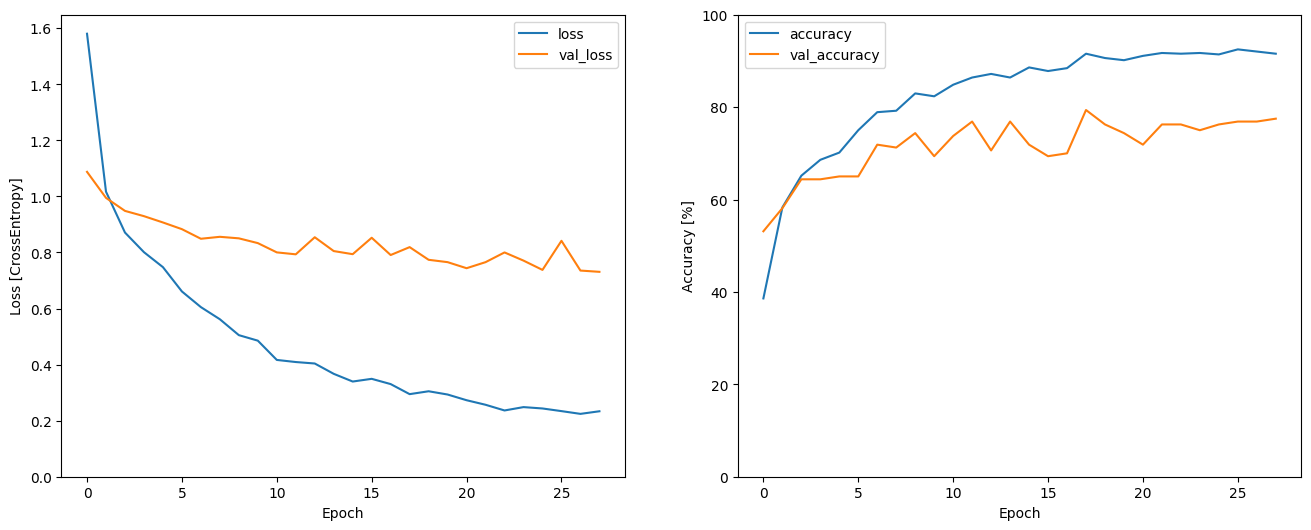

In [ ]:
metrics_cnn = history_cnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_cnn.epoch, metrics_cnn['loss'], metrics_cnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_cnn.epoch, 100*np.array(metrics_cnn['accuracy']), 100*np.array(metrics_cnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Matriz de confusion

In [ ]:
y_pred_cnn = model_cnn.predict(val_spectrogram_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


In [ ]:
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)

In [ ]:
y_true_cnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

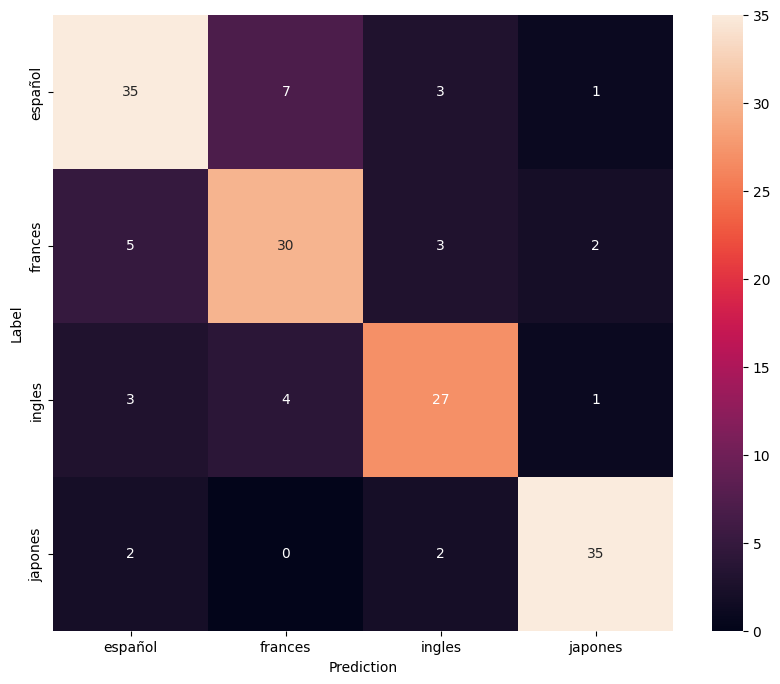

In [ ]:
confusion_mtx_cnn = tf.math.confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_cnn,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferimos sobre un archivo nuevo


Vemos las predicciones sobre un audio nuevo.

Realizamos un gráfico para visualizar las probabilidades por clase de la predicción, y además reproducimos el audio

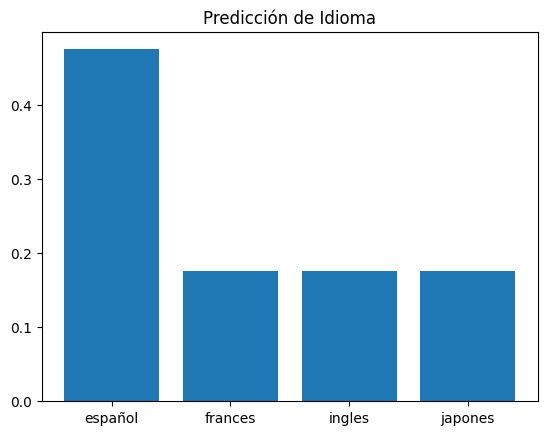

In [ ]:
# Ruta de los datos
data_dir = pathlib.Path("/content/drive/My Drive/datasets_tensorflow/dataset_reducido/español")

# Ruta del archivo de audio
x = data_dir / '18376955264167537.wav'

# Lee y decodifica el archivo de audio
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1)
x = tf.squeeze(x, axis=-1)  # Elimina la dimensión redundante
waveform = x

# Función para obtener el espectrograma
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Genera el espectrograma
x = get_spectrogram(waveform)

# Asegúrate de que el espectrograma tenga 3 dimensiones (altura, ancho, canales)
x = x[..., tf.newaxis]  # [frames, frequency_bins, 1]

# Ajusta el tamaño del espectrograma
x = tf.image.resize(x, [2361, 129])  # [2361, 129, 1]

# Agrega la dimensión de batch
x = x[tf.newaxis, ...]  # [1, 2361, 129, 1]

# Predicción del modelo
prediction = model_cnn(x)

# Etiquetas de las clases
x_labels = label_names

# Gráfico de barras de la predicción
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicción de Idioma')
plt.show()

# Reproducir el audio original
display.display(display.Audio(waveform, rate=16000))


# Modelo con RNNs

## Con conversión a espectogramas

Volvemos a montar Drive para luego poder volver a cargar los datos y procesarlos corresctamente para las redes RNNs

In [ ]:
drive.mount('/content/drive', force_remount= True)
data_dir = '/content/drive/My Drive/datasets_tensorflow/dataset_reducido'
classes = os.listdir(data_dir)
num_classes = len(classes)

Mounted at /content/drive


### Preprocesamiento de datos

Creamos varias funciones para preprocesar los audios:
* **preprocess_audio:** unifica la duración de los audios a 10 segundos cada uno. Si el audio es más largo se trunca y si es más corto se rellena con padding (0 hasta completar los 10 segundos)
* **split_audio_with_overlap:** divide cada audio de 10 segundos en 4 audios más cortos (de 2,5 segundos) con un overlapping de la mitad (1,25 segundos)
* **load_audio_classification_dataset:** carga los audios desde la carpeta 'dataset_reducido' de Google Drive, aplica las dos funciones anteriores y genera un espectograma de cada segmento de audio.
Luego normaliza los espectogramas para que vayan todos entre 0 y 1, y vuelve a verificar que todos los espectogramas tengan la misma longitud (310 frames).
Y por último divide los datos en x e y asociando cada espectograma con su etiqueta correspondiente de idioma codificadas con one-hot.

*Nota:* El valor de 310 frames sale de una fórmula en relación a la duración del audio, y el tamaño de ventana (hop_length) calculada como $ n frames=[
(n samples - n fft)/ hop length]+1 $

In [ ]:
fixed_length = 10  # Duración fija en segundos
num_parts = 4  # Dividir audio en 4 partes
part_length = fixed_length / num_parts  # Duración de cada parte
part_stride = part_length / 2  # Superposición de la mitad de cada parte

def preprocess_audio(audio, sr, fixed_length):
    # Ajustar duración del audio
    target_length = int(fixed_length * sr)
    if len(audio) > target_length:
        # Truncar si es más largo
        audio = audio[:target_length]
    elif len(audio) < target_length:
        # Padding si es más corto
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def split_audio_with_overlap(audio, sr, num_parts, part_length, part_stride):
    # Dividir audio en partes con overlapping
    part_samples = int(part_length * sr)
    stride_samples = int(part_stride * sr)
    segments = []

    for i in range(num_parts):
        start_sample = i * stride_samples
        end_sample = start_sample + part_samples
        if end_sample <= len(audio):
            segments.append(audio[start_sample:end_sample])
    return segments

def load_audio_classification_dataset(data_dir, fixed_length, num_parts, part_length, part_stride):
    X, y = [], []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for audio_name in os.listdir(class_dir):
            audio_path = os.path.join(class_dir, audio_name)
            try:
                # Cargar audio
                y_audio, sr = librosa.load(audio_path, sr=16000)

                # Preprocesar audio (truncar o padding)
                y_audio = preprocess_audio(y_audio, sr, fixed_length)

                # Dividir en partes con overlapping
                segments = split_audio_with_overlap(y_audio, sr, num_parts, part_length, part_stride)

                for segment in segments:
                    # Transformar a espectrograma
                    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
                    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

                    # Normalizar el espectrograma (0 a 1)
                    spectrogram_db = (spectrogram_db - np.min(spectrogram_db)) / (np.max(spectrogram_db) - np.min(spectrogram_db))

                    # Asegurarnos que todos los espectrogramas tengan exactamente 310 frames
                    if spectrogram_db.shape[1] < 310:  # Si tiene menos de 310 frames
                        spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, 310 - spectrogram_db.shape[1])), mode='constant')
                    elif spectrogram_db.shape[1] > 310:  # Si tiene más de 310 frames
                        spectrogram_db = spectrogram_db[:, :310]  # Recortar a los primeros 310 frames

                    X.append(spectrogram_db)
                    y.append(label)
            except Exception as e:
                print(f"Error procesando {audio_name}: {e}")

    X = np.array(X)
    y = to_categorical(y, num_classes)
    return X, y

# Cargar y preprocesar los datos
X, y = load_audio_classification_dataset(data_dir, fixed_length, num_parts, part_length, part_stride)


Dividimos los datos en train y validación, haciendo antes un shuffle para evitar que el modelo aprenda patrones de los datos

In [ ]:
# Mezclar los datos
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Definimos el modelo

Definimos un modelo con capas convolucionales para capturar las características de las imágenes (espectogramas) individuales, capas LSTM para capturar relaciones temporales, y capas densas para realizar la clasificación basándose en las características aprendidas.

In [ ]:
# Definir el modelo
model_audio = Sequential()

# Capas convolucionales 1D
model_audio.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_audio.add(Conv1D(32, kernel_size=3, activation='relu'))
model_audio.add(MaxPooling1D(pool_size=2))
model_audio.add(Conv1D(64, kernel_size=3, activation='relu'))
model_audio.add(Conv1D(64, kernel_size=3, activation='relu'))
model_audio.add(MaxPooling1D(pool_size=2))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.4))
model_audio.add(Conv1D(128, kernel_size=3, activation='relu'))
model_audio.add(Conv1D(128, kernel_size=3, activation='relu'))

# Capa recurrente (LSTM)
model_audio.add(LSTM(64, return_sequences=False, dropout=0.5))

# Capas de salida
model_audio.add(Dense(64, activation='relu'))
model_audio.add(Dropout(0.5))
model_audio.add(Dense(num_classes, activation='softmax'))

# Resumen del modelo
model_audio.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_47 (Conv1D)                   │ (None, 126, 32)             │          29,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_48 (Conv1D)                   │ (None, 124, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 60, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 58, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 29, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 27, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_52 (Conv1D)                   │ (None, 25, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,524 (701.27 KB)

 Trainable params: 179,396 (700.77 KB)

 Non-trainable params: 128 (512.00 B)

### Compilamos y entrenamos el modelo

Entrenamos durante 50 épocas con EarlyStopping para frenar el entrenamiento si el val_accuracy no mejora durante 10 épocas seguidas, y un chekpoint para que guarde el modelo con el mejor desempeño en términos de val_accuracy.

In [ ]:
model_audio.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_audio_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model_audio.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=8,
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8693 - loss: 0.3938 - val_accuracy: 0.5891 - val_loss: 1.2863
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8521 - loss: 0.4191 - val_accuracy: 0.8391 - val_loss: 0.4548
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8719 - loss: 0.3850 - val_accuracy: 0.7672 - val_loss: 0.6823
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8619 - loss: 0.3889 - val_accuracy: 0.7734 - val_loss: 0.6018
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8548 - loss: 0.4296 - val_accuracy: 0.7141 - val_loss: 0.8582
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8660 - loss: 0.3782 - val_accuracy: 0.7937 - val_loss: 0.5873
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8631 - loss: 0.3752 - val_accuracy: 0.7922 - val_loss: 0.5630
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8696 - loss: 0.3518 - 

Podemos ver que el valor de val_accuracy subio un poco con respecto al modelo de CNN, y además si bien vemos que aprende un poco más de los datos de entrenamiento, overfittea mucho menos. Dándonos como mejor época los valores: accuracy: 0.9146 - val_accuracy: 0.8938

### Evaluamos el modelo

#### Gráficos

Gráficamos el accuracy y loss tanto de train como de test para ver como evolucionan.

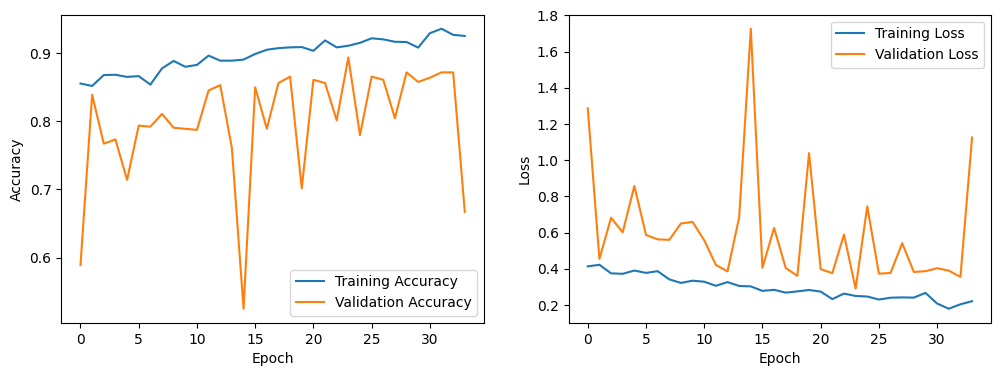

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Matriz de confusión

Creamos una matriz de confusión para evaluar las predicciones del modelo.

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


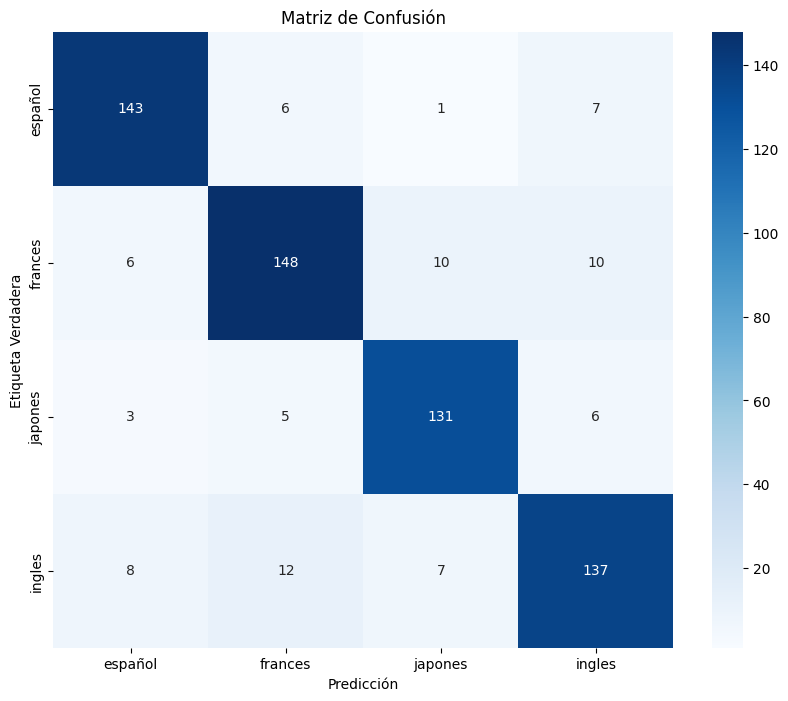

In [ ]:
# Predicción en datos de validación
y_pred_rnn = model_audio.predict(X_val)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
y_true_rnn = np.argmax(y_val, axis=1)

# Matriz de confusión
confusion_mtx_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_rnn, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

#### Inferimos sobre un nuevo audio

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


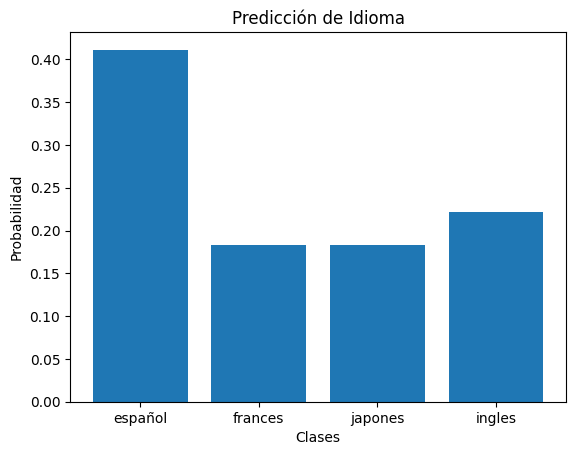

In [ ]:
# Ruta del archivo de audio
audio_path = '/content/drive/My Drive/datasets_tensorflow/dataset_reducido/español/18376955264167537.wav'

# Cargar el archivo de audio
y_audio, sr = librosa.load(audio_path, sr=16000)

# Preprocesar el audio (truncar o rellenar para que dure 10 segundos)
y_audio = preprocess_audio(y_audio, sr, fixed_length)

# Dividir el audio en partes con overlapping
segments = split_audio_with_overlap(y_audio, sr, num_parts, part_length, part_stride)

# Generar predicciones para cada segmento
predictions = []
for segment in segments:
    # Convertir el segmento en un espectrograma mel
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Normalizar el espectrograma (0 a 1)
    spectrogram_db = (spectrogram_db - np.min(spectrogram_db)) / (np.max(spectrogram_db) - np.min(spectrogram_db))

    # Asegurar dimensiones `(128, 310)`
    if spectrogram_db.shape[1] < 310:  # Padding si tiene menos de 310 frames
        spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, 310 - spectrogram_db.shape[1])), mode='constant')
    elif spectrogram_db.shape[1] > 310:  # Recorte si tiene más de 310 frames
        spectrogram_db = spectrogram_db[:, :310]

    # Convertir en tensor 3D (batch_size=1, height=128, width=310)
    spectrogram_db = np.expand_dims(spectrogram_db, axis=0)  # Batch size

    # Predicción
    prediction = model_audio.predict(spectrogram_db)
    predictions.append(prediction)

# Promediar las predicciones de los segmentos
avg_prediction = np.mean(predictions, axis=0)
predicted_class = np.argmax(avg_prediction)

# Etiquetas de las clases
x_labels = classes

# Graficar la predicción
plt.bar(x_labels, tf.nn.softmax(avg_prediction[0]))
plt.title('Predicción de Idioma')
plt.ylabel('Probabilidad')
plt.xlabel('Clases')
plt.show()

# Reproducir el audio original
ipd.display(ipd.Audio(audio_path, rate=16000))

## Sin conversión a espectograma

#### Preprocesamiento de los audios

Al igual que en la parte del modelo RNNs, volvemos a cargar los datos y los volvemos a procesar.

Las funciones preprocess_audio y split_audio_with_overlap son iguales que cuando convertimos a espectogramas con overlapping.

La diferencia está en la función load_audio_classification_dataset, que en este caso no convierte los segmentos a espectograma, sino que los divide y maneja los audios en crudo.

In [4]:
drive.mount('/content/drive', force_remount= True)

data_dir = '/content/drive/My Drive/datasets_tensorflow/dataset_reducido'
classes = os.listdir(data_dir)
num_classes = len(classes)

fixed_length = 10  # Duración fija en segundos
sr = 16000  # Tasa de muestreo
num_parts = 4  # Dividir audio en 4 partes
part_length = fixed_length / num_parts  # Duración de cada parte
part_stride = part_length / 2  # Superposición de la mitad de cada parte

def preprocess_audio(audio, sr, fixed_length):
    # Ajustar duración del audio
    target_length = int(fixed_length * sr)
    if len(audio) > target_length:
        # Truncar si es más largo
        audio = audio[:target_length]
    elif len(audio) < target_length:
        # Padding si es más corto
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def split_audio_with_overlap(audio, sr, num_parts, part_length, part_stride):
    # Dividir audio en partes con overlapping
    part_samples = int(part_length * sr)
    stride_samples = int(part_stride * sr)
    segments = []

    for i in range(num_parts):
        start_sample = i * stride_samples
        end_sample = start_sample + part_samples
        if end_sample <= len(audio):
            segments.append(audio[start_sample:end_sample])
    return segments

def load_audio_classification_dataset(data_dir, fixed_length, sr, num_parts, part_length, part_stride):
    X, y = [], []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for audio_name in os.listdir(class_dir):
            audio_path = os.path.join(class_dir, audio_name)
            try:
                # Cargar audio
                y_audio, sr_actual = librosa.load(audio_path, sr=sr)

                # Preprocesar audio (truncar o padding)
                y_audio = preprocess_audio(y_audio, sr, fixed_length)

                # Dividir en partes con overlapping
                segments = split_audio_with_overlap(y_audio, sr, num_parts, part_length, part_stride)

                # Agregar cada segmento como entrada
                for segment in segments:
                    X.append(segment)
                    y.append(label)
            except Exception as e:
                print(f"Error procesando {audio_name}: {e}")

    X = np.array(X)
    y = to_categorical(y, num_classes)
    return X, y

# Cargar y preprocesar los datos
X, y = load_audio_classification_dataset(data_dir, fixed_length, sr, num_parts, part_length, part_stride)
print(f"Forma de los datos de entrada: {X.shape}")
print(f"Forma de las etiquetas: {y.shape}")

Mounted at /content/drive
Forma de los datos de entrada: (3200, 40000)
Forma de las etiquetas: (3200, 4)


### Definimos el modelo

Definimos un modelo con capas convolucionales para capturar las características de las imágenes (espectogramas) individuales, capas LSTM para capturar relaciones temporales, y capas densas para realizar la clasificación basándose en las características aprendidas.

In [5]:
from tensorflow.keras.layers import Bidirectional

# Agregar dimensión extra (canales)
X = np.expand_dims(X, axis=-1)

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_audio2 = Sequential()

# Capas convolucionales 1D
model_audio2.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model_audio2.add(MaxPooling1D(pool_size=2))
model_audio2.add(Conv1D(64, kernel_size=3, activation='relu'))
model_audio2.add(MaxPooling1D(pool_size=2))
model_audio2.add(Conv1D(128, kernel_size=3, activation='relu'))
model_audio2.add(MaxPooling1D(pool_size=2))
model_audio2.add(BatchNormalization())
model_audio2.add(Dropout(0.4))

# Capa recurrente (LSTM Bidireccional)
model_audio2.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.5)))
model_audio2.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.5)))

# Capas de salida
model_audio2.add(Dense(128, activation='relu'))
model_audio2.add(Dropout(0.5))
model_audio2.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_audio_model.keras', monitor='val_loss', save_best_only=True)

# Compilar y entrenar el modelo
model_audio2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_audio2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 203s 609ms/step - accuracy: 0.2698 - loss: 1.3861 - val_accuracy: 0.2656 - val_loss: 1.3865
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 194s 605ms/step - accuracy: 0.2904 - loss: 1.3744 - val_accuracy: 0.2484 - val_loss: 1.3815
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 605ms/step - accuracy: 0.3143 - loss: 1.3754 - val_accuracy: 0.2234 - val_loss: 1.4033
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 604ms/step - accuracy: 0.3007 - loss: 1.3726 - val_accuracy: 0.2750 - val_loss: 1.3775
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 604ms/step - accuracy: 0.3051 - loss: 1.3595 - val_accuracy: 0.2969 - val_loss: 1.3617
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 604ms/step - accuracy: 0.3223 - loss: 1.3555 - val_accuracy: 0.2891 - val_loss: 1.3601
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 603ms/step - accuracy: 0.3185 - loss: 1.3535 - val_accuracy: 0.2719 - val_loss: 1.3766
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 604ms/step - accuracy: 0.3193 -

Observamos un rendimiento considerablemente menor que en los modelos anteriores, y además en este caso tarda muchísimo más tiempo en correr

### Evaluamos el modelo

#### Graficos

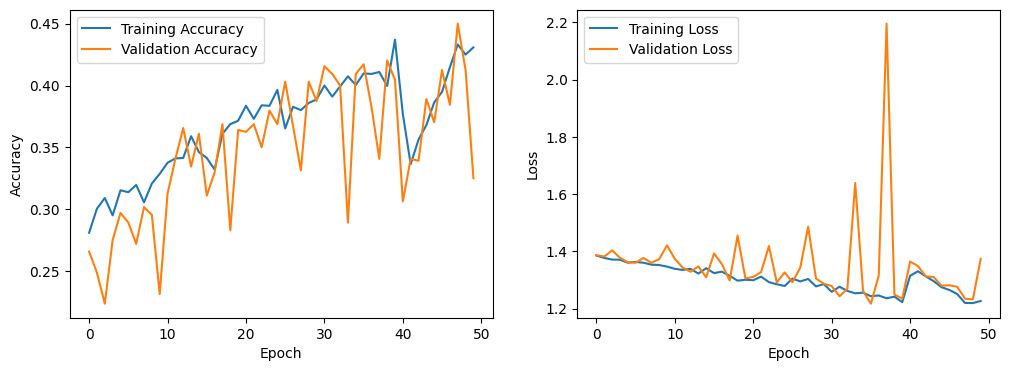

In [7]:
# Visualización de los resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Matriz de confusión

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step


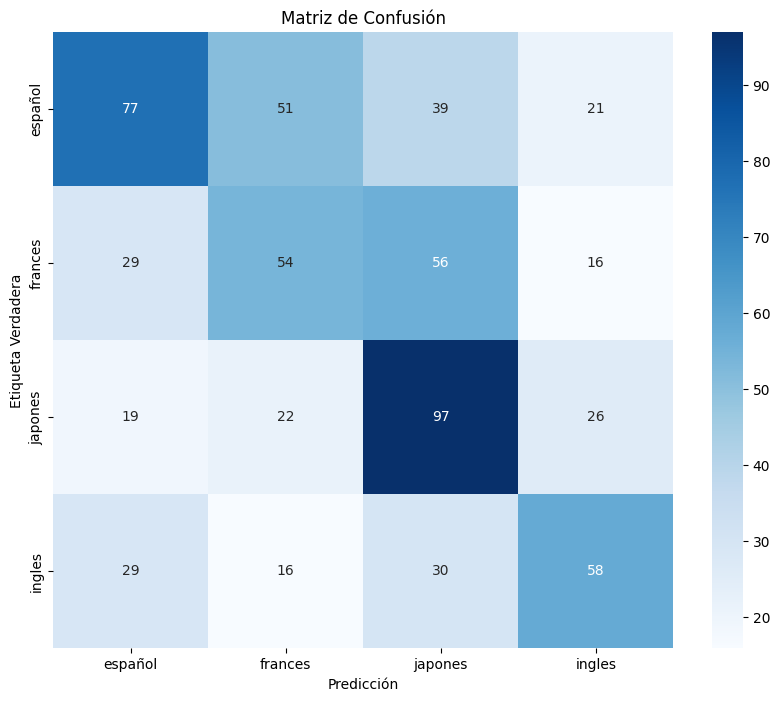

In [8]:
# Predicción en datos de validación
y_pred_rnn = model_audio2.predict(X_val)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)  # Índices de las clases predichas
y_true_rnn = np.argmax(y_val, axis=1)  # Índices de las clases verdaderas

# Matriz de confusión
confusion_mtx_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_rnn, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

#### Inferimos sobre un nuevo archivo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


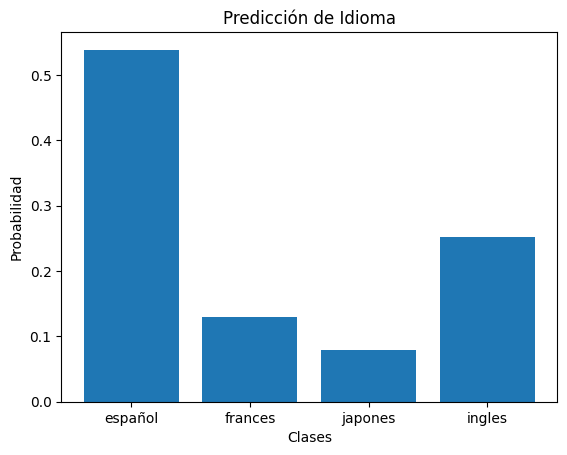

In [12]:
# Ruta del archivo de audio
audio_path = '/content/drive/My Drive/datasets_tensorflow/dataset_reducido/español/18376955264167537.wav'

# Cargar el archivo de audio
y_audio, sr_actual = librosa.load(audio_path, sr=None)
if sr_actual != sr:
    y_audio = librosa.resample(y_audio, orig_sr=sr_actual, target_sr=sr)

# Preprocesar el audio (truncar o rellenar para que dure 10 segundos)
y_audio = preprocess_audio(y_audio, sr, fixed_length)

# Dividir el audio en partes con overlapping
segments = split_audio_with_overlap(y_audio, sr, num_parts, part_length, part_stride)

# Generar predicciones para cada segmento
predictions = []
for segment in segments:
    # Expandir dimensiones para que coincidan con la entrada del modelo (1D -> 3D)
    segment = np.expand_dims(segment, axis=0)  # Batch size = 1
    segment = np.expand_dims(segment, axis=-1)  # Agregar dimensión de características

    # Predicción del modelo
    prediction = model_audio2.predict(segment)
    predictions.append(prediction)

# Promediar las predicciones de los segmentos
avg_prediction = np.mean(predictions, axis=0)
avg_prediction = np.squeeze(avg_prediction)

# Etiquetas de las clases
x_labels = classes

# Verificar consistencia entre etiquetas y predicciones
if len(x_labels) != len(avg_prediction):
    raise ValueError("El número de etiquetas no coincide con el tamaño de las predicciones promedio.")

# Graficar la predicción
plt.bar(x_labels, avg_prediction)
plt.title('Predicción de Idioma')
plt.ylabel('Probabilidad')
plt.xlabel('Clases')
plt.show()

import IPython.display as ipd

# Reproducir el audio original
ipd.display(ipd.Audio(audio_path, rate=sr))

# Conclusiones finales

Si bien todos los modelos lograron predecir correctamente el idioma español en las pruebas realizadas, y los gráficos de probabilidades mostraron resultados similares, utilizamos el accuracy de cada modelo como criterio principal para decidir cuál implementar.

En la siguiente tabla comparativa podemos ver las diferentes métricas del accuracy tanto para train como para validación de cada uno de los modelos implementados:

| Modelo                  | Accuracy (Train) | Accuracy (Val) |
|-------------------------|------------------|----------------|
| CNN                    | 0.9309           | 0.7937         |
| RNN (espectograma)     | 0.9146           | 0.8938         |
| RNN (audio)            | 0.3870           | 0.4203         |

* **Modelo con Redes Recurrentes (espectrogramas):**
Este modelo mostró el mejor balance entre accuracy de train y validación, con un accuracy de validación de 0.8938. Esto lo convierte en la mejor opción para este problema, ya que muestra una buena generalización en datos que no vio anteriormente.

* **Modelo con Redes Convolucionales (CNN):**
Aunque tuvo el accuracy de train mayor (0.9309), en validación fue un poco menor (0.7937), lo que muestra claramente un caso de overfitting. A pesar de intentar simplificar el modelo, los resultados no mejoraron, por lo que no es la opción ideal.

* **Modelo con Redes Recurrentes (audio sin transformación):**
Este modelo tiene las métricas más bajas en ambos conjuntos de datos (accuracy de entrenamiento: 0.3870, validación: 0.4203), incluso muestra underfitting. Además, este modelo requiere mucho más tiempo de procesamiento, lo que hace que no sea una buena opción desde ningún punto de vista

**Conclusión:**
En resumen, el modelo con redes recurrentes usando espectrogramas es el que mejor funciona para este problema. Tiene un buen balance entre los resultados de entrenamiento y validación, y generaliza bien con datos nuevos. Por eso, creemos que es la mejor opción para clasificar idiomas en base a los audios.
